# Complemento Laboratorio 1 MA4702-2021
# Resolución de TSP por generación de filas


Este archivo contiene las funciones y ejemplos para resolver TSP usando generación por restricciones. 
Puede basarse en este modelo para resolver Steiner Tree en el laboratorio 1.

In [1]:
@show(Sys.BINDIR)
versioninfo()
import Pkg
# Descomente los siguientes comandos y vuelvalos a comentar una vez que los ejecute
# Pkg.add("Distances")
# Pkg.add("Plots")
# Pkg.update("JuMP")
Pkg.status("JuMP")
using JuMP, Gurobi, Distances, Plots
include("preparacion.jl");
const GUROBI_ENV = Gurobi.Env() # Abrir un solo ambiente de Gurobi, 
# Jupyter se marea si se crean demasiados modelos durante en una misma celda, esto lo evita.

Sys.BINDIR = "C:\\Users\\gurti\\AppData\\Local\\Programs\\Julia 1.5.4\\bin"
Julia Version 1.5.4
Commit 69fcb5745b (2021-03-11 19:13 UTC)
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: AMD Ryzen 5 3500U with Radeon Vega Mobile Gfx  
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-9.0.1 (ORCJIT, znver1)
Status `C:\Users\gurti\.julia\environments\v1.5\Project.toml`
  [4076af6c] JuMP v0.21.6
Academic license - for non-commercial use only - expires 2021-05-24


Gurobi.Env(Ptr{Nothing} @0x000000004d79ff00, false, 0)

### Modelo DFZ (Dantzig-Fulkerson-Johnson) no dirigido para TSP.
Datos. $(d_e\colon e\in E)$ son la distancias entre las ciudades. 
Variables: $z_e$ para todo $e\in E$ que representarán la indicatriz del ciclo.

\begin{align*}
(\text{DFZ})\qquad \min &\sum_{e\in E} z_{e}d(e)\\
z(\delta(v))&=2, & \forall v\in V.\quad &(\text{grado}(v))\\
z(\delta(U))&\geq 2,& \forall U\subseteq V, U\neq \emptyset, U\neq V.\quad &(\text{corte}(U))\\
0\leq z_e &\leq 1, &\forall e\in E.\quad &(\text{cotas}(e))\\
z &\in \mathbb{Z}^{E}.& &(\text{integralidad})
\end{align*}

# Función para ejercicio 1

La siguiente función crear el modelo-incompleto DFZ en Gurobi **sin incluir las restricciones de corte**.

In [2]:
function creaModeloDFZ(N,coordx, coordy)
    
    # Inicializar modelo y condiciones del solver
    DFZ = Model(optimizer_with_attributes(() -> Gurobi.Optimizer(GUROBI_ENV)))  # ver comentario en primera celda
    set_optimizer_attributes(DFZ, "OutputFlag" => 0, "TimeLimit" => 80)
    
    # Crear variables, objetivos y restricciones
    E=[[i,j] for i in 1:N, j in 1:N if i<j]
    @variable(DFZ, 0<=z[i in 1:N,j in 1:N; [i,j] in E]<=1, Int)   
    @objective(DFZ, Min, sum(z[e[1],e[2]]*euclidean([coordx[e[1]],coordy[e[1]]],[coordx[e[2]],coordy[e[2]]]) for e in E))
    @constraint(DFZ, grado[i in 1:N], sum(z[e[1],e[2]] for e in E if i in e)==2)
    
    # Devolver modelo.
    return DFZ
end
 

creaModeloDFZ (generic function with 1 method)

In [3]:
#Leer el archivo i20.txt y crear el modelo asociado.  
N,posx,posy=leearchivo("i20.txt")
DFZ=creaModeloDFZ(N,posx,posy);

In [4]:
#optimizar y recuperar vector indicatriz
optimize!(DFZ)
@show(objective_value(DFZ));
F=[[i,j] for i in 1:N, j in 1:N if i<j && value(DFZ[:z][i,j]) ≈ 1];
@show(F);

objective_value(DFZ) = 91.7478217204953
F = [[2, 3], [6, 7], [2, 8], [1, 9], [5, 10], [6, 11], [7, 11], [1, 12], [3, 13], [12, 13], [8, 14], [14, 15], [9, 16], [15, 17], [16, 17], [4, 18], [4, 19], [5, 19], [10, 20], [18, 20]]


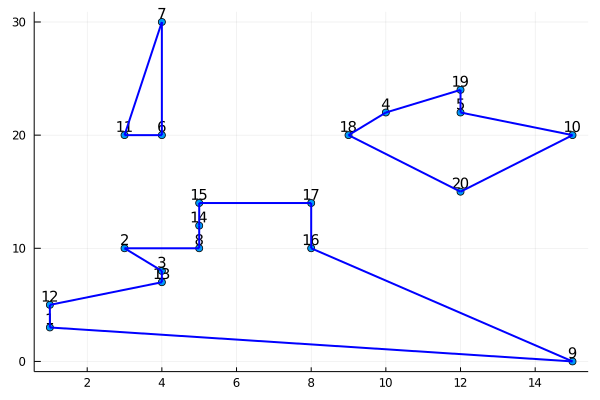

U = [1, 12, 13, 3, 2, 8, 14, 15, 17, 16, 9]


In [5]:
#dibujar la solucion, y encontrar la componente que contiene al vertice 1
U=encuentracomponente(N,1,F);
dibujaaristas(posx,posy,F);
@show(U);

# Función para ejercicio 2

La siguiente resuelve DFZ mediante generación de restricciones.
Este procedimiento está basado en la siguiente idea.

Dada una solución $z$ entera para DFZ sin las restricciones de corte, llamamos $F$ al conjunto indicatriz de $z$ y $U$ a la componente de $(V,F)$ que contiene a 1. Si $U$ tiene $N$ elementos (i.e., $U=V$) entonces, como $F$ satisface las restricciones de grado, se deduce que $F$ es un ciclo Hamiltoniano y luego $z$ satisface todas las restricciones de corte. Si por el contrario, $U$ tiene menos de $N$ elementos, entonces $z(\delta(U))=0$ y luego la restricción corte$(U)$ es insatifecha, por lo que se puede agregar esa restricción al modelo.


In [6]:
function resuelveDFZ(nombre_archivo)
    
    # Crear modelo DFZ inicial 
    N,posx,posy = leearchivo(nombre_archivo)
    DFZ=creaModeloDFZ(N,posx,posy);
    E=[[i,j] for i in 1:N, j in 1:N if i<j]

    # iterar (guardando número de iteraciones simplex calculadas)
    limite=80
    itera=0
    cortesagregados=0
    simplex=0
    while (itera<limite) 
        # optimizar modelo actual y recuperar vector indicatriz
        optimize!(DFZ)
        F=[[i,j] for i in 1:N, j in 1:N if i<j && value(DFZ[:z][i,j]) ≈ 1];     
                    
        # sumar a simplex el número de iteraciones usadas
        simplex=simplex + simplex_iterations(DFZ)
        
        # encontrar componente U que tiene a 1. Use 
        U = encuentracomponente(N,1,F)
        
        
        if (length(U)==N) # si la componente pasa por las N ciudades, calcular el valor del tour, escribir el ciclo y dibujarlo.
            valorTour=objective_value(DFZ)
            display("Número de iteraciones: $itera")
            display("Número de cortes agregados: $cortesagregados")
            display(string("Número de pasos simplex:", Int(simplex)))                        
            display("Tour óptimo encontrado, de largo $valorTour")
            display("Lista de ciudades : $U")
            dibujaaristas(posx,posy,F)
            return nothing
                        
        else # la componente no toca todos los terminales, luego se debe añadir la restriccion de corte
            
            ##(ojo, debido a distintos cambios usadas por JuMP, las restricciones nuevas deben usar variables con el nombre modelo[:nombrevariable])
            ## Ejemplo, para añadir la restriccion "z[1,2]>= 1" se debe escribir
            ## @contraint(DFZ, DFZ[:z][1,2]>=1)
            ##
            
            #@constraint(DFZ, sum(DFZ[:z][e[1],e[2]] for e in E if length(intersect(e,U))==1)>=2) # muy lento
            @constraint(DFZ, sum(DFZ[:z][e[1],e[2]] for e in E if (e[1] in U && !(e[2] in U)) || (e[2] in U && !(e[1] in U)))>=2)
            cortesagregados+=1
        end                
                                                
    itera=itera+1
    println("Iteración $itera, cortes $cortesagregados")                                                
    end  
    return nothing
end

resuelveDFZ (generic function with 1 method)

"Número de iteraciones: 4"

"Número de cortes agregados: 4"

"Número de pasos simplex:170"

"Tour óptimo encontrado, de largo 94.30307786906482"

"Lista de ciudades : [1, 12, 13, 3, 2, 8, 14, 15, 6, 11, 7, 18, 4, 19, 5, 10, 20, 17, 16, 9]"

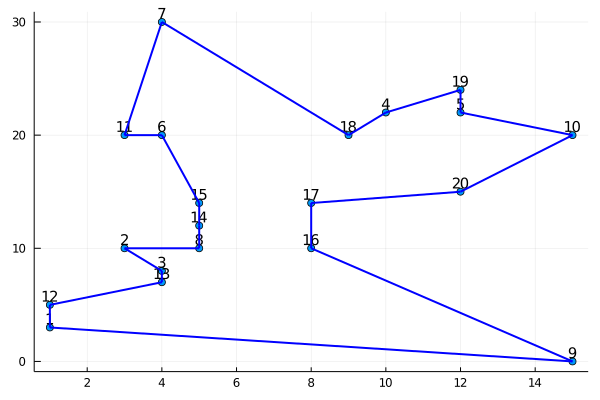

Iteración 1, cortes 1
Iteración 2, cortes 2
Iteración 3, cortes 3
Iteración 4, cortes 4
  1.855558 seconds (1.22 M allocations: 65.074 MiB)


In [7]:
@time resuelveDFZ("i20.txt")

Iteración 1, cortes 1
Iteración 2, cortes 2
Iteración 3, cortes 3
Iteración 4, cortes 4

"Número de iteraciones: 6"

"Número de cortes agregados: 6"

"Número de pasos simplex:513"

"Tour óptimo encontrado, de largo 519.7445914513304"

"Lista de ciudades : [1, 19, 23, 24, 21, 22, 26, 35, 15, 6, 36, 13, 7, 9, 12, 20, 33, 29, 10, 11, 16, 30, 17, 32, 18, 25, 5, 31, 4, 27, 14, 2, 28, 3, 34, 8]"

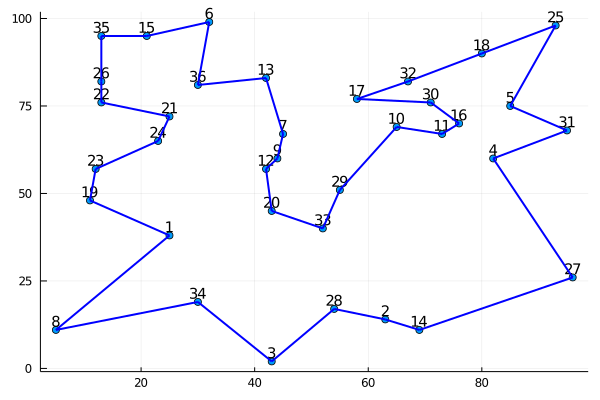


Iteración 5, cortes 5
Iteración 6, cortes 6
  0.370950 seconds (228.66 k allocations: 11.430 MiB)


In [8]:
@time resuelveDFZ("i40.txt")

Iteración 1, cortes 1
Iteración 2, cortes 2
Iteración 3, cortes 3
Iteración 4, cortes 4
Iteración 5, cortes 5
Iteración 6, cortes 6
Iteración 7, cortes 7
Iteración 8, cortes 8
Iteración 9, cortes 9
Iteración 10, cortes 10
Iteración 11, cortes 11
Iteración 12, cortes 12
Iteración 13, cortes 13
Iteración 14, cortes 14

"Número de iteraciones: 15"

"Número de cortes agregados: 15"

"Número de pasos simplex:1450"

"Tour óptimo encontrado, de largo 570.8967196956396"

"Lista de ciudades : [1, 32, 27, 4, 25, 23, 38, 5, 34, 18, 14, 37, 48, 41, 7, 24, 40, 2, 35, 8, 49, 3, 13, 50, 46, 21, 26, 47, 33, 16, 17, 28, 15, 44, 45, 30, 10, 6, 9, 12, 11, 43, 36, 22, 39, 31, 42, 29, 19, 20]"

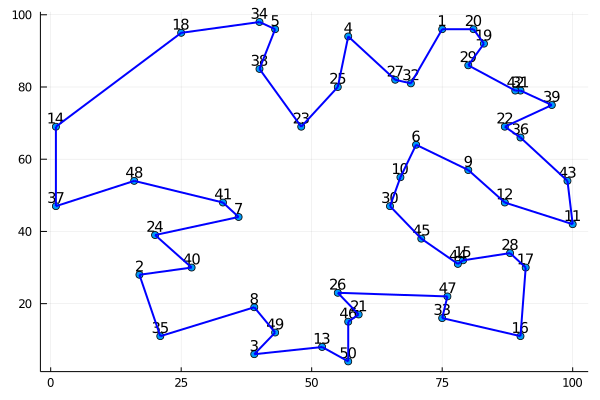


Iteración 15, cortes 15
  0.909230 seconds (554.33 k allocations: 24.186 MiB, 7.89% gc time)


In [9]:
@time resuelveDFZ("i50.txt")

# Función para ejercicio 3

La siguiente función resuelve DFZ usando callbacks.


In [10]:
function resuelveDFZconCallbacks(nombrearchivo)
    
    # Crear modelo DFZ inicial 
    N,posx,posy = leearchivo(nombrearchivo)
    DFZ=creaModeloDFZ(N,posx,posy);
    
    # Implementar función callback
    cortes=0
    callbacks=0
    function mi_callback(cb_data)
        callbacks+=1
        
        ## Recupera valores intermedios de cb_data y DFZ[:z]
        z_val=zeros(N,N)
        for i=1:N, j=i+1:N
            z_val[i,j] = callback_value(cb_data, DFZ[:z][i,j])
        end    
        
        # Revisar fraccionalidad del vector de valores encontrado, si no es integral, return nothing
        tolerancia=0.001
        if (!all( u-> abs(u-round(u))<tolerancia, z_val))
          display(string("callback en solución fraccional"))
          return nothing
        end
      
        ## Encontrar vector indicatriz F asociado
        F=[[i,j] for i in 1:N, j in 1:N if i<j && z_val[i,j] ≈ 1];     
                    
        ## Calcular componente que pasa por 1
        U = encuentracomponente(N,1,F)
        
        if (length(U)<N) ## si la componente no pasa por las N ciudades
            E=[[i,j] for i in 1:N, j in 1:N if i<j]
            restriccion_nueva = @build_constraint(sum(DFZ[:z][e[1],e[2]] for e in E if (e[1] in U && !(e[2] in U)) || (e[2] in U && !(e[1] in U)))>=2)
            MOI.submit(DFZ, MOI.LazyConstraint(cb_data), restriccion_nueva)
            cortes+=1
        end
        println("callbacks $callbacks, cortes $cortes")
    end                        
    
    MOI.set(DFZ, MOI.LazyConstraintCallback(), mi_callback)

    #Optimizar, reportar solución y dibujar.
    optimize!(DFZ)
    valorTour = objective_value(DFZ)
    F=[[i,j] for i in 1:N, j in 1:N if i<j && value(DFZ[:z][i,j]) ≈ 1];
    componente = encuentracomponente(N,1,F)                                     
    
    display(string("Tour óptimo encontrado, de largo ", valorTour))
    display(string("Lista de ciudades :", componente))
    display(string("Número de pasos simplex:", Int(simplex_iterations(DFZ))))
    display(string("Número de callbacks:", callbacks))
    display(string("Número de cortes agregados:", cortes))
    dibujaaristas(posx,posy,F)
    return nothing
end    

resuelveDFZconCallbacks (generic function with 1 method)

"Tour óptimo encontrado, de largo 94.30307786906482"

"Lista de ciudades :[1, 12, 13, 3, 2, 8, 14, 15, 6, 11, 7, 18, 4, 19, 5, 10, 20, 17, 16, 9]"

"Número de pasos simplex:49"

"Número de callbacks:9"

"Número de cortes agregados:6"

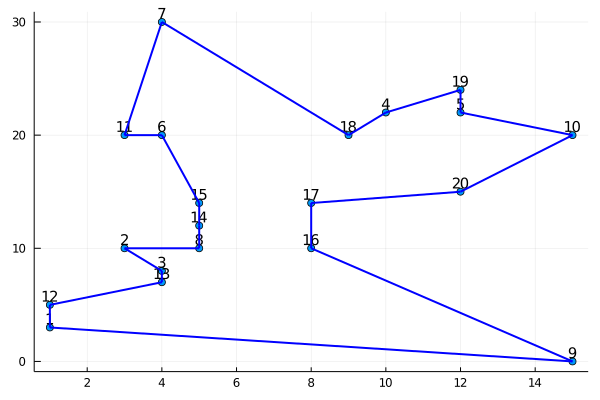

callbacks 1, cortes 1
callbacks 2, cortes 2
callbacks 3, cortes 3
callbacks 4, cortes 4
callbacks 5, cortes 4
callbacks 6, cortes 4
callbacks 7, cortes 5
callbacks 8, cortes 6
callbacks 9, cortes 6
  1.429198 seconds (1.30 M allocations: 66.616 MiB, 2.87% gc time)


In [11]:
@time resuelveDFZconCallbacks("i20.txt")

callbacks 1, cortes 0
callbacks 2, cortes 1
callbacks 3, cortes 2
callbacks 4, cortes 3
callbacks 5, cortes 4
callbacks 6, cortes 5
callbacks 7, cortes 6
callbacks 8, cortes 7
callbacks 9, cortes 8
callbacks 10, cortes 9
callbacks 11, cortes 10
callbacks 12, cortes 11
callbacks 13, cortes 11
callbacks 14, cortes 12
callbacks 15, cortes 13
callbacks 16, cortes 14
callbacks 17, cortes 15
callbacks 18, cortes 16
callbacks 19, cortes 17


"Tour óptimo encontrado, de largo 519.7445914513304"

"Lista de ciudades :[1, 19, 23, 24, 21, 22, 26, 35, 15, 6, 36, 13, 7, 9, 12, 20, 33, 29, 10, 11, 16, 30, 17, 32, 18, 25, 5, 31, 4, 27, 14, 2, 28, 3, 34, 8]"

"Número de pasos simplex:62"

"Número de callbacks:26"

"Número de cortes agregados:22"

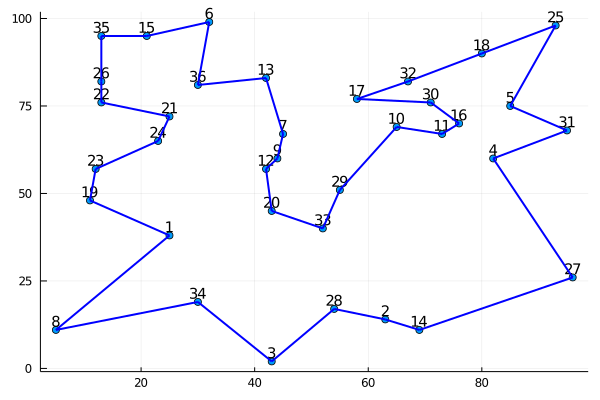

callbacks 20, cortes 18
callbacks 21, cortes 18
callbacks 22, cortes 19
callbacks 23, cortes 20
callbacks 24, cortes 21
callbacks 25, cortes 22
callbacks 26, cortes 22
  0.327822 seconds (345.57 k allocations: 18.577 MiB)


In [12]:
@time resuelveDFZconCallbacks("i40.txt")

callbacks 1, cortes 0
callbacks 2, cortes 1
callbacks 3, cortes 2
callbacks 4, cortes 3
callbacks 5, cortes 4
callbacks 6, cortes 4
callbacks 7, cortes 5
callbacks 8, cortes 6
callbacks 9, cortes 7
callbacks 10, cortes 8
callbacks 11, cortes 9
callbacks 12, cortes 10
callbacks 13, cortes 11
callbacks 14, cortes 12
callbacks 15, cortes 13
callbacks 16, cortes 14
callbacks 17, cortes 14
callbacks 18, cortes 15
callbacks 19, cortes 16
callbacks 20, cortes 17
callbacks 21, cortes 18
callbacks 22, cortes 19
callbacks 23, cortes 20

"Tour óptimo encontrado, de largo 570.8967196956396"

"Lista de ciudades :[1, 32, 27, 4, 25, 23, 38, 5, 34, 18, 14, 37, 48, 41, 7, 24, 40, 2, 35, 8, 49, 3, 13, 50, 46, 21, 26, 47, 33, 16, 17, 28, 15, 44, 45, 30, 10, 6, 9, 12, 11, 43, 36, 22, 39, 31, 42, 29, 19, 20]"

"Número de pasos simplex:129"

"Número de callbacks:29"

"Número de cortes agregados:25"

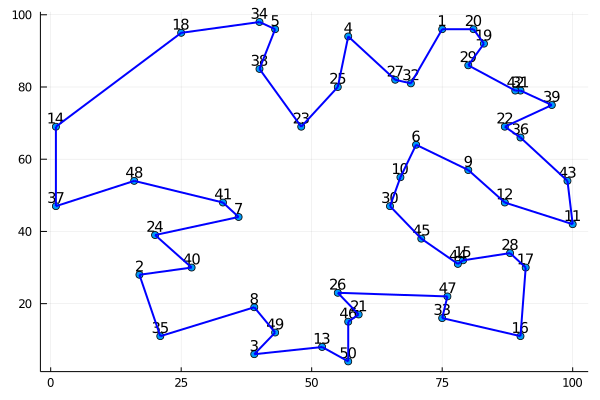


callbacks 24, cortes 21
callbacks 25, cortes 22
callbacks 26, cortes 23
callbacks 27, cortes 24
callbacks 28, cortes 25
callbacks 29, cortes 25
  0.565957 seconds (614.64 k allocations: 32.602 MiB, 8.72% gc time)


In [13]:
@time resuelveDFZconCallbacks("i50.txt")

# Función para ejercicio 4.

El siguiente PL puro permite calcular el $s$-$t$ corte mínimo en un grafo dirigido completo, donde $Z(i,j)$ es dato.


\begin{align*}
min \sum_{i=1}^N\sum_{j=1}^N &q_{i,j}Z_{i,j}\\
p_s&\geq 1\\
p_t&=0\\
p_i-p_j+q(j,i)&\geq 0\\
q&\ge 0
\end{align*}


Aquí las variables son los vectores q (largo) y p (potencial). Básicamente el PL busca asignar potenciales entre 0 y 1 a cada vértice y llama $q(i,j)$ a la diferencia de potencial entre $i$ y $j$. En un mundo ideal, una solución óptima asignaría potenciales 0 a aquellos puntos en el lado de $t$ y potencial 1 a aquellos puntos en el lado de $s$ del corte y luego $q_e=1$ solo para los arcos que cruzan el corte. Esta idea también funciona de manera fraccional y de hecho se puede probar que 
$$S=\{i \in [N], p_i\geq \alpha\}$$
es un $s$-$ t$ corte minimo para cualquier $\alpha$ entre 0 y 1.



In [14]:
# calcula el mincut de s a t usando los valores de Z en un digrafo completo de N nodos.
function cut(N, s, t, Z)
    mincut = Model(optimizer_with_attributes(() -> Gurobi.Optimizer(GUROBI_ENV))) 
    set_optimizer_attributes(mincut, "OutputFlag" => 0, "TimeLimit" => 50)
    @variable(mincut, q[i=1:N, j=1:N]>=0)
    @variable(mincut, p[i=1:N])
    @objective(mincut, Min, sum(q[i,j]*Z[i,j] for i in 1:N, j in 1:N))
    @constraints(mincut, begin
            p[s]>=1
            p[t]==0
            Potencial[i=1:N,j=1:N], p[i]-p[j]+q[j,i]>=0
        end)
    optimize!(mincut)
    valor=objective_value(mincut)
    corte=findall(x->x>=1/2, value.(p))
    return valor, corte
end

cut (generic function with 1 method)

In [15]:
# La siguiente función encuentra una solución óptima de la relajación fraccional de DFZ

function resuelveDFZfraccional(nombrearchivo) 
    # Crear modelo DFZ inicial 
    N,posx,posy=leearchivo(nombrearchivo)
    DFZ=creaModeloDFZ(N,posx,posy);
    
    # Remover integralidad
    E=[[i,j] for i in 1:N, j in 1:N if i<j]
    for e in E
        unset_integer(DFZ[:z][e[1],e[2]])
    end
    
     
    iter=0
    listo=false
    epsilon=0.0001 # tolerancia
    simplex=0
    cortesagregados=0
    
    while (!listo)
        listo=true #si no encontramos cortes nuevo en la ejecución, terminamos al final del loop.
        iter=iter+1
                    
        # optimizar, aumentar numero iteraciones simplex 
        optimize!(DFZ)
        simplex+=simplex_iterations(DFZ)
                    
        println("Iteración: ",iter, ", valor fraccional: ", objective_value(DFZ))
        
        # Crear capacidades Z bidirigidas a partir del PL resuelto 
        
        Z=zeros(N,N)
        for i in 1:N, j in i+1:N
            Z[i,j]=value(DFZ[:z][i,j])
            Z[j,i]=Z[i,j]
        end
        
        # Para cada t vértice, calcular el 1-t corte mínimo. Si se encuentra uno de valor menor que 2-epsilon,
        # agregar y continuar.
                    
        for t in 2:N
            valor, U = cut(N,1,t,Z) 
            if (valor < 2-epsilon)
                @constraint(DFZ, sum(DFZ[:z][e[1],e[2]] for e in E if (e[1] in U && !(e[2] in U)) || (e[2] in U && !(e[1] in U)))>=2)
                cortesagregados+=1
                listo=false
                break
            end
        end
    end
    
    # Solución encontrada, reportarla, reportar el numero de iteraciones simplex y dibujarla

    valorTour=objective_value(DFZ)
    display(string("Tour fraccional encontrado de largo ", valorTour))
    display(string("Número de pasos simplex:", Int(simplex_iterations(DFZ))))
    display(string("Número de cortes agregados:", cortesagregados))

    pesos=zeros(N,N)
    for i in 1:N, j in i+1:N
        pesos[i,j]=value(DFZ[:z][i,j])
    end
    dibujapesos(posx,posy,pesos)
    return nothing
end



resuelveDFZfraccional (generic function with 1 method)

Iteración: 1, valor fraccional: 91.34275108899965
Iteración: 2, valor fraccional: 91.7478217204953
Iteración: 3, valor fraccional: 92.6121477938552
Iteración: 4, valor fraccional: 94.12273798156588


"Tour fraccional encontrado de largo 94.30307786906482"

"Número de pasos simplex:1"

"Número de cortes agregados:5"

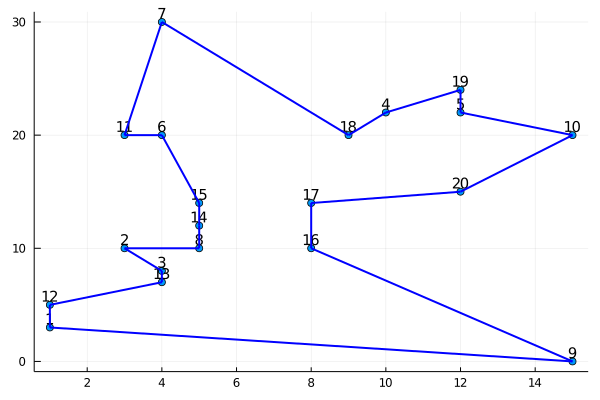

Iteración: 5, valor fraccional: 94.25107800219563
Iteración: 6, valor fraccional: 94.30307786906482
  2.500785 seconds (2.59 M allocations: 145.360 MiB, 1.98% gc time)


In [16]:
@time(resuelveDFZfraccional("i20.txt"))

Iteración: 1, valor fraccional: 505.01688668480654
Iteración: 2, valor fraccional: 506.2848512712791
Iteración: 3, valor fraccional: 515.9685895053087
Iteración: 4, valor fraccional: 517.1518940945627
Iteración: 5, valor fraccional: 517.1832953566363

"Tour fraccional encontrado de largo 517.194224093172"

"Número de pasos simplex:1"

"Número de cortes agregados:5"

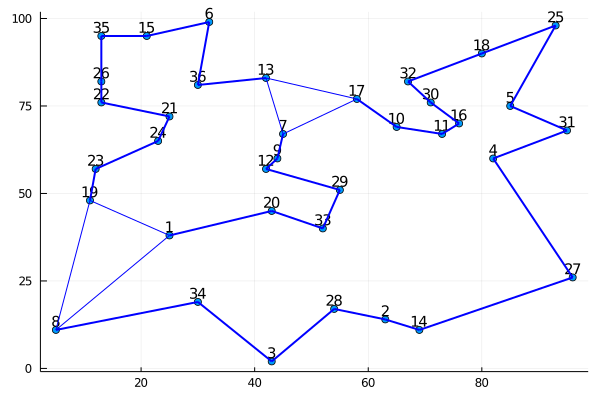


Iteración: 6, valor fraccional: 517.194224093172
  1.579075 seconds (3.49 M allocations: 249.665 MiB, 11.24% gc time)


In [17]:
@time(resuelveDFZfraccional("i40.txt"))

Iteración: 1, valor fraccional: 546.7299351198719
Iteración: 2, valor fraccional: 554.1270591673496
Iteración: 3, valor fraccional: 554.8715731082694
Iteración: 4, valor fraccional: 561.8835548861971
Iteración: 5, valor fraccional: 562.6571909924617
Iteración: 6, valor fraccional: 563.2052252356134
Iteración: 7, valor fraccional: 564.4935714627709
Iteración: 8, valor fraccional: 564.6447430864573
Iteración: 9, valor fraccional: 567.5885446547452
Iteración: 10, valor fraccional: 568.2491182223898
Iteración: 11, valor fraccional: 568.2644317326025
Iteración: 12, valor fraccional: 568.4156033562889
Iteración: 13, valor fraccional: 568.6561720216126
Iteración: 14, valor fraccional: 569.7501140191986
Iteración: 15, valor fraccional: 570.4779481512368
Iteración: 16, valor fraccional: 570.7455480719532

"Tour fraccional encontrado de largo 570.8967196956397"

"Número de pasos simplex:2"

"Número de cortes agregados:16"

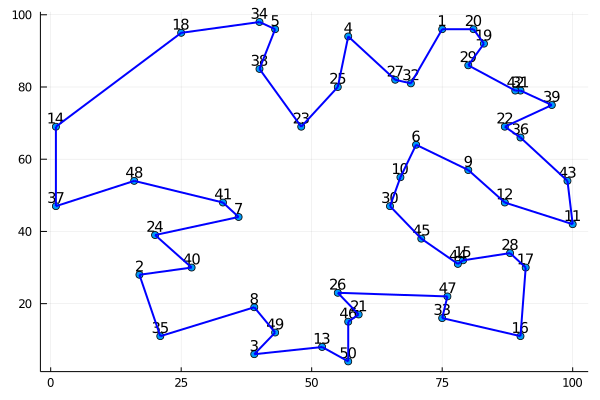


Iteración: 17, valor fraccional: 570.8967196956397
  4.401156 seconds (13.23 M allocations: 889.906 MiB, 7.90% gc time)


In [18]:
@time(resuelveDFZfraccional("i50.txt"))